In [1]:
!pip install git+https://github.com/fastai/fastai.git &> /dev/null

## 01:25:14 - Collaborative filtering and latent factors

* What is collab filtering?
  * On Netflix, you might be watching scifi movies made in 70s.
  * Could find other people that have watched the same movies you've watched, and can recommend other films they've watched that you haven't. 
* Foundation of this idea is that there are some features in items (ie movies) called latent factors that can be "uncovered"

## 01:28:09 - MovieLens

*  Contains tens of millions of movie rankings:

In [2]:
from fastai.collab import *
from fastai.tabular.all import *
import pandas as pd

In [3]:
path = untar_data(URLs.ML_100k)

* Main table can be opened with pandas:
  * Note that there's no header, so we provide our own column names.

In [4]:
ratings = pd.read_csv(
    path/'u.data', delimiter='\t', header=None,
    names=['user', 'movie', 'rating', 'timestamp'])

In [5]:
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


## 01:28:53 - Question: do you perform cross-validation in Deep Learning?

* Doing cross-validation or not is more a question about dataset size.
* Less common now due to bigger data sizes.
* Still used in Kaggle competitions where metric accuracy is quite important.

## 01:30:32 - Question: what other applications for collab filtering other than recommender system are there?

* Depends on how you define recommender system: diagnosis patients, figuring out what a person is likely to click on are sort of recommender systems.

## 01:31:19 - Question: how would you approach video classification?

* Usually approached as image classification per frame.
* Could also make the 4th axis time, but it would require a lot of memory.

## 01:33:20 - MovieLens cont.

* `ML_100k` is a small subset of the full dataset (there's a 25M dataset too).
* Can cross tab to get a better idea of what the dataset is:

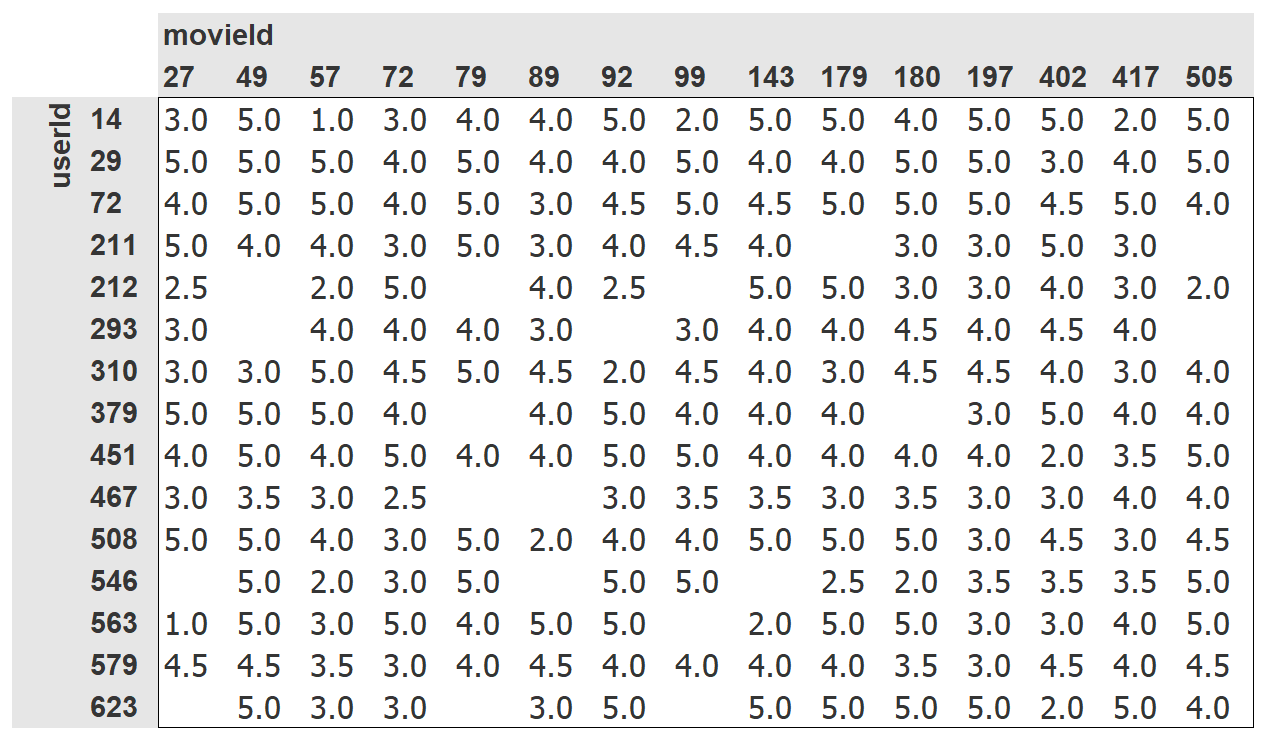

## 01:35:32 - Latent factors

* Assume you have columns for each movie that described: how much action, how much drama and how much comedy on a scale of -1 to 1.

In [6]:
import numpy as np

In [7]:
last_movie = np.array([0.95, -0.9, -0.9])

* We could then describe a user based on their preferences for those rating categories:

In [8]:
user1 = np.array([0.9, -0.8, 0.6])

* We can then do element-wise multiplication to tell us how much they correlate:

In [9]:
(user1 * last_movie).sum()

1.0350000000000001

* Multiplying 2 vectors and adding the results is called: [[Dot Product]]
* We could calculate the match between a less action-packed movie:

In [10]:
blue_valentine = np.array([-0.99, 0.99, 0.2])

In [11]:
(user1*blue_valentine).sum()

-1.5630000000000002

* We don't actually know what the latent factors are in our dataset: but we can learn them.

## 01:37:51 - Learning latent factors

* We can visualise it in Excel, starting by setting latent factors to random values

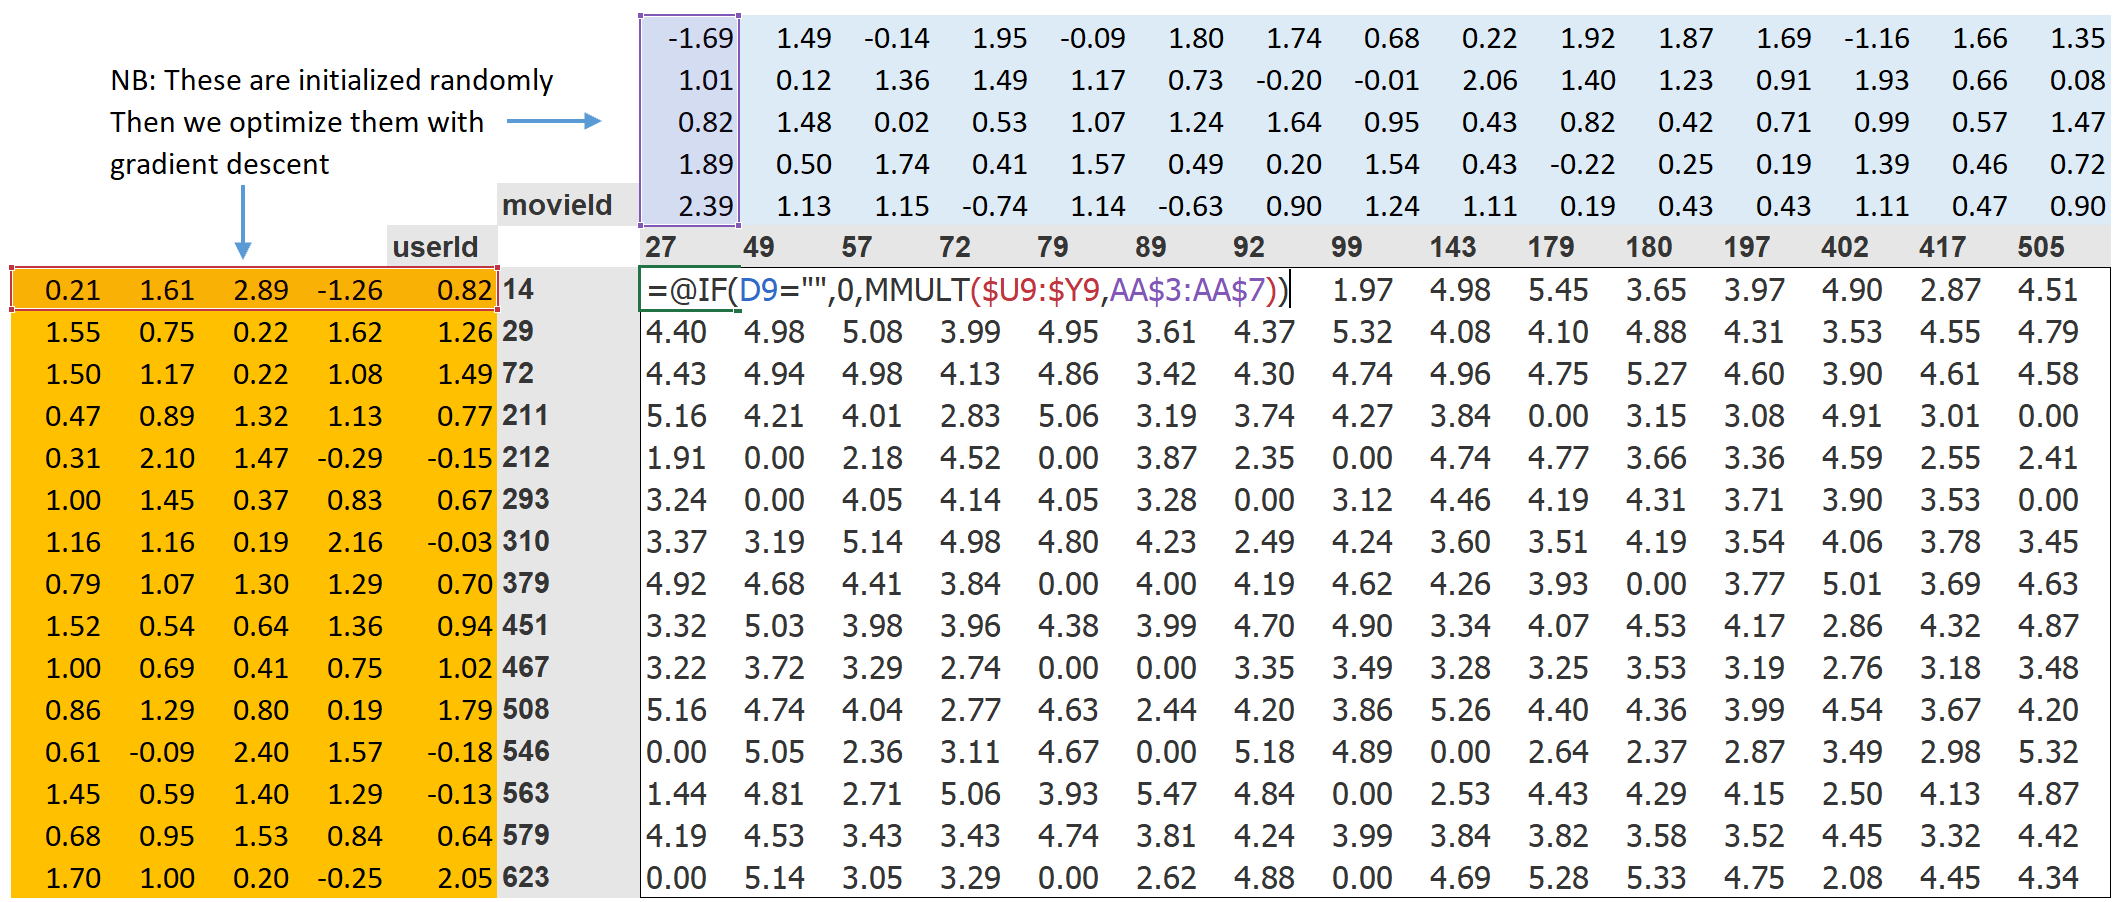

* A matrix multiple of a row by column is identical of dot product of 2 vectors
* To do it in PyTorch, we start by replacing movie id with title. Just to make it easier to look at:

In [12]:
movies = pd.read_csv(
    path/'u.item', delimiter='|', encoding='latin-1',
    usecols=(0, 1), names=('movie', 'title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


* `merge` by default will merge on a shared column name.

In [13]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


* Can then build `DataLoaders` object from table.
  * Takes first column for user by default.
  * Use `item_name` to specify item column  

In [14]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()

,user,title,rating
0,883,"City of Lost Children, The (1995)",4
1,504,Private Benjamin (1980),3
2,826,Drop Zone (1994),3
3,333,Fargo (1996),4
4,716,Citizen Kane (1941),5
5,600,Blade Runner (1982),5
6,252,Twelve Monkeys (1995),4
7,429,Vanya on 42nd Street (1994),3
8,152,It Could Happen to You (1994),5
9,184,Mrs. Doubtfire (1993),4


* Can represent movie and user latent factors as simple matrices:

In [15]:
n_users = len(dls.classes['user'])
n_movies = len(dls.classes['title'])
n_factors = 5

user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

* `randn` returns normally distributed numbers.
* Look up in index is not an operation deep learning models can do
  * However, can represent look up in index as matrix product with a one-hot encoded vector

In [16]:
one_hot_3 = one_hot(3, n_users).float()
user_factors.t() @ one_hot_3

tensor([-0.0480,  0.9249,  1.5718,  0.3341,  1.1332])

In [17]:
user_factors[3]

tensor([-0.0480,  0.9249,  1.5718,  0.3341,  1.1332])

## 01:47:34 - Question: how different is collab filtering with sparse data compared to dense data?

* See fastai Linear Algebra course.

## 01:47:58 - Question: in practise, should we tune the number of latent factors?

* Yes. It's another hyperparameter that can be tuned.

## 01:48:16 - Embedding

* Doing matrix multiplication with a matrix of one-hot encoded vctors is an inefficient way to do the computation.
* Embedding:
  * A computational shortcut
  * Has the gradients of a one-hot matrix multiplication
  * Has the speed of an array lookup

## 01:50:38 - Object-oriented programming

* In PyTorch, a model archiecture is a class that inherits from `nn.Module`
* Class syntax:

```
class Dog:
  def __init__(self, name):
      self.name
  
  def speak(self):
       print(f'{self.name} says wolf')
```

* The `__init__` method is the classes constructor and is referred to as a "dunder method" (double underscore).
* The syntax for inheritance is as follows:

```
class Hound(Dog):
   def speak(self):
      print(f'{self.name} the hound says wolf')
```

## 01:53:40 - Module in PyTorch

* `Module` is a PyTorch class that fastai has customised:

In [18]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return (users * movies).sum(dim=1)

* Function `forward` gets the user id and movie id as 2 columns.
* We can use those to lookup the embeddings.

In [19]:
x, y = dls.one_batch()
x.shape

torch.Size([64, 2])

* We can now use a standard Learner to train the model

In [20]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

In [21]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.310729,1.323857,00:09
1,1.053884,1.083242,00:09
2,0.935609,0.968261,00:09
3,0.819087,0.883527,00:09
4,0.723053,0.870461,00:09


* To improve the results, we can make it better by forcing predictions between 0 and 5 using `sigmoid_range`

In [22]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0, 5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return sigmoid_range((users * movies).sum(dim=1), *self.y_range)

In [23]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

In [24]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.993796,0.993444,00:09
1,0.866043,0.903248,00:09
2,0.656823,0.877895,00:09
3,0.483619,0.880073,00:09
4,0.381787,0.884775,00:09


## 01:59:02 - Bias term

* When we multiple the latent factors, it doesn't take account of the fact that some users rate movies badly. Or a movie is universally loved.
  * We can add a single number for each movie and user, that it added to the result which takes that into account.

In [25]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0, 5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
    
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1)

        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:, 1])
        res = (users * movies).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
        return sigmoid_range(res, *self.y_range)

In [26]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.024781,1.009018,00:09
1,0.846310,0.906241,00:09
2,0.660873,0.875660,00:09
3,0.484015,0.880105,00:09
4,0.379380,0.884129,00:09


## 02:01:05 - Regularisation

* We can see that the model appears to be overfitting quickly.
* With images, we have data augmentation. What can we use in collab filtering to allow training for longer? Regularisation
* To look at next week.